Let's load up the data and do a little feature engineering; we want to make as many variables as possible to be numerical, so let's convert some to booleans.

In [1]:
import pandas as pd

df = pd.read_csv(filepath_or_buffer='/kaggle/input/heart-failure-prediction/heart.csv')
df['Sex'] = df['Sex'] == 'M'
df['FastingBS'] = df['FastingBS'] == 1
df['HeartDisease'] = df['HeartDisease'] == 1
df['ExerciseAngina'] = df['ExerciseAngina'] == 'Y'
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,True,ATA,140,289,False,Normal,172,False,0.0,Up,False
1,49,False,NAP,160,180,False,Normal,156,False,1.0,Flat,True
2,37,True,ATA,130,283,False,ST,98,False,0.0,Up,False
3,48,False,ASY,138,214,False,Normal,108,True,1.5,Flat,True
4,54,True,NAP,150,195,False,Normal,122,False,0.0,Up,False


What do our unique values look like?

In [2]:
df.nunique().to_frame().T

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,50,2,4,67,222,2,3,119,2,53,3,2


Let's pick our model's input variables and target variable.

In [3]:
TARGET = 'HeartDisease'
COLUMNS = ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak']

What does our class balance look like?

In [4]:
df[TARGET].value_counts(normalize=True).to_frame().T

HeartDisease,True,False
proportion,0.553377,0.446623


Our target variable is nearly balanced; True outnumbers False about 11 to 9.

Next let's use TSNE to do some dimensionality reduction so we can visualize our data.

In [5]:
from sklearn.manifold import TSNE

reducer = TSNE(random_state=2025)
df[['x', 'y']] = reducer.fit_transform(df[COLUMNS])

Let's see what we've got.

<Axes: xlabel='x', ylabel='y'>

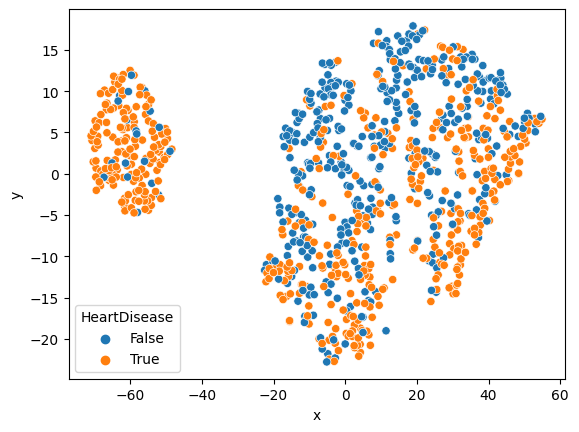

In [6]:
from seaborn import scatterplot

scatterplot(data=df, x='x', y='y', hue=TARGET)

What do we see? TSNE clusters our data into two neat clusters; one of them is almost all True, but the other is mixed. We should probably have moderate expectations regarding our model accuracy. Let's build a model and find out.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[COLUMNS], df[TARGET], test_size=0.25, random_state=2025, stratify=df[TARGET])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 250 iterations
accuracy: 0.8000
f1: 0.7979
              precision    recall  f1-score   support

       False       0.82      0.71      0.76       103
        True       0.79      0.87      0.83       127

    accuracy                           0.80       230
   macro avg       0.80      0.79      0.79       230
weighted avg       0.80      0.80      0.80       230



Our model accuracy is moderate; what do our feature importances look like?

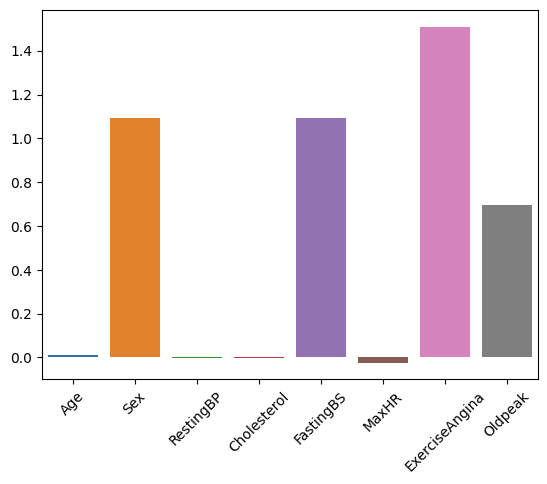

In [8]:
import numpy as np
from seaborn import barplot

ax = barplot(x=np.array(COLUMNS), y=np.array(logreg.coef_[0]))
ax.tick_params(axis='x', rotation=45)

It's probably not surprising that Sex and Angina are important variables; is it surprising that the age and heart rate variables are not?

Let's take a look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

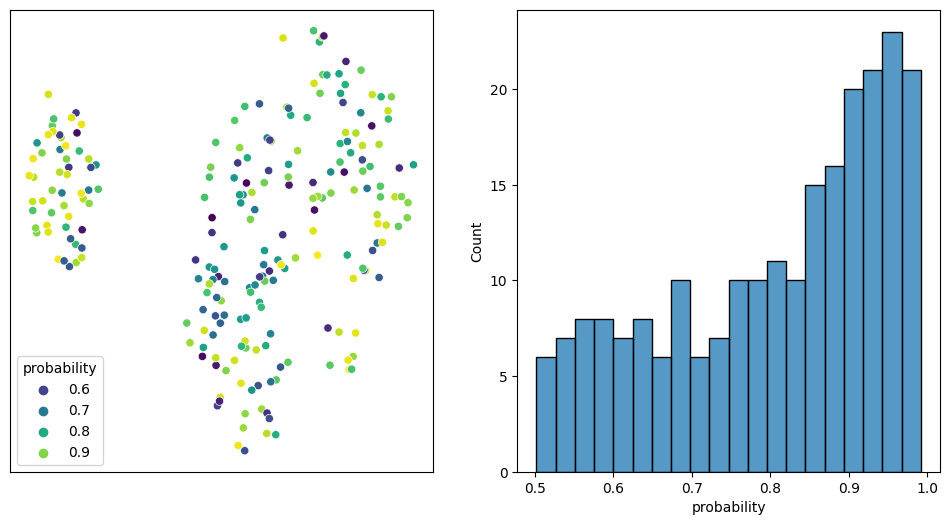

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')


plot_df = df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

_, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilities are kind of all over the place; maybe it is surprising that we have low model probabilities in both of our clusters.